# Data Cleaning

Data source https://www.kaggle.com/datasets/hendratno/covid19-indonesia

This Indonesian COVID-19 dataset is a collection of open data sources, providing a time series of COVID-19 pandemic events from both the country level to the province level. It includes pandemic data, demographic data, and derived values. 

 The data cleaning process will take place across three broad areas:
* Importing: importing libraries, global colors, and data importing
* Data Cleaning: checking data types, filtering data, and removing outliers
* Saving Data: exporting CSV files

# | 1.0 Imports

## || 1.1 Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing

While shades of grey are preferred for impartial interpretation of data, colours are used here for clarity on computer screens:

In [2]:
# global colors
data_color = "#282828" # grey
model_color = "#00BBF9" # blue
background_color = "#f5f5f5" #light grey
grid_color = "#DADADA" # mid grey

## || 1.2 Data

The Kaggle dataset is in CSV format and saved locally in the data folder. It is imported into a dataframe, with the number of columns and rows checked against expected respective values:

In [3]:
# dataset location column and row information
data_set = "./data/raw/covid_19_indonesia_time_series_all.csv"
expected_columns = 38
expected_rows = 21759

# load local dataset into dataframe
raw_data = pd.read_csv(data_set)

# check if loaded data matches the expected data
if raw_data.shape[0] == expected_rows:
    print("✅ Rows:\t{}".format(expected_rows))
else:
    print("❌ Rows:\tExpected: {}, Actual: {}".format(expected_rows, raw_data.shape[0]))

if raw_data.shape[1] == expected_columns:
    print("✅ Columns:\t{}".format(expected_columns))
else:
    print("❌ Columns:\tExpected: {},\t  Actual: {}".format(expected_columns, raw_data.shape[1]))

✅ Rows:	21759
✅ Columns:	38


The imported dataframe is displayed for a quick visual inspection prior to continuing:

In [4]:
# force pandas to display all columns and print first 3 lines
pd.set_option('display.max_columns', None)
raw_data.head(3)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,100.00%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN


# | 2.0 Data Cleaning

## || 2.1 Data Types

Inspecting the data types reveals a potential problem with the format of the date column. It is subsequently converted to a datetime format inspection:

In [5]:
# check data types are appropriate for intended use
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21759 entries, 0 to 21758
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         21759 non-null  object 
 1   Location ISO Code            21759 non-null  object 
 2   Location                     21759 non-null  object 
 3   New Cases                    21759 non-null  int64  
 4   New Deaths                   21759 non-null  int64  
 5   New Recovered                21759 non-null  int64  
 6   New Active Cases             21759 non-null  int64  
 7   Total Cases                  21759 non-null  int64  
 8   Total Deaths                 21759 non-null  int64  
 9   Total Recovered              21759 non-null  int64  
 10  Total Active Cases           21759 non-null  int64  
 11  Location Level               21759 non-null  object 
 12  City or Regency              0 non-null      float64
 13  Province        

In [6]:
# change date data type to avoid errors in time series sorting
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format="%m/%d/%Y")

# check date data type has been updated
if pd.api.types.is_datetime64_ns_dtype(raw_data["Date"]):
    print("✅ Date column is in datetime")
else:
    print("❌ Date column is not in datetime")

✅ Date column is in datetime


## || 2.2 Missing Values

A heatmap is used to quickly visualise any missing values in the dataset:

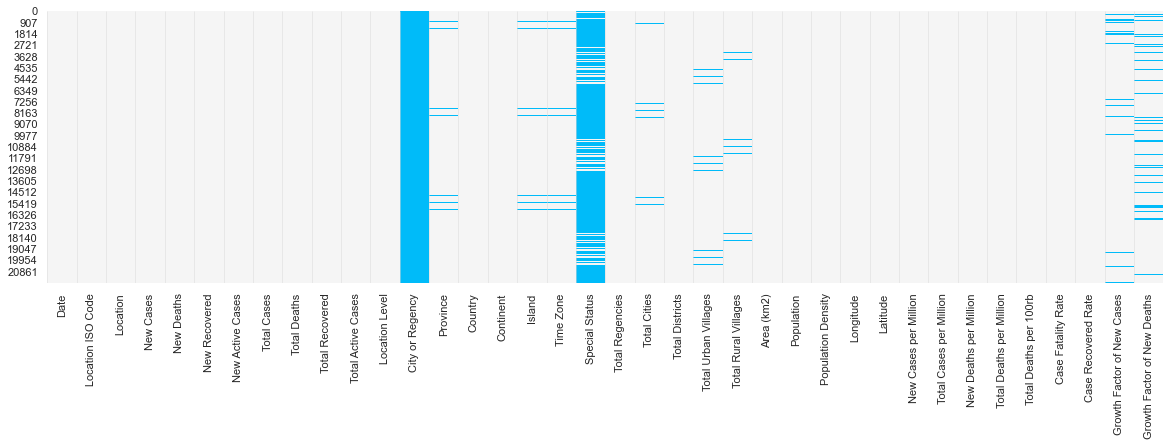

In [7]:
# visualise missing values using a heat map
sns.set(rc={"figure.figsize": (20, 5)})
sns.heatmap(raw_data.isnull(), cmap=[background_color, model_color], cbar=False)
plt.vlines(x=np.arange(raw_data.shape[1]), ymin=0, ymax=raw_data.shape[0], color=grid_color, linewidths=0.5)
plt.show()

Some missing values are either of no interest or too difficult to restore. Furthermore, some columns are unreleated to the research questions. Both types of columns can be dropped for a more refined dataset:

In [8]:
# list of columns to drop
columns_drop = ["Location ISO Code", "Location Level", "City or Regency", "Province", "Country", "Continent", "Island", "Time Zone", "Special Status", "Total Regencies", "Total Cities", "Total Districts", "Total Urban Villages", "Total Rural Villages", "Longitude", "Latitude", "New Cases per Million", "Total Cases per Million", "New Deaths per Million", "Total Deaths per Million", "Total Deaths per 100rb", "Case Fatality Rate", "Case Recovered Rate", "Growth Factor of New Deaths"]

# drop columns in the list
raw_data = raw_data.drop(columns_drop, axis=1)

# check columns are no longer present
if not any(col in raw_data.columns for col in columns_drop):
    print("✅ Dropped columns are no longer present in the dataframe")
else:
    print("❌ Dropped columns are still present in the dataframe")

✅ Dropped columns are no longer present in the dataframe


However, the Growth Factor of New Cases is relevant. The growth factor is calculated based on previous day data in the same location. As it is derived data, all the data is recalculated rather than attempting to fill gaps. The unique locations are filtered into a temporary dataframe, growth calculated, and the temporary dataframe concatenated to a fresh one which is reindexed afterwards:

In [9]:
# updated dataframe location sections will be added to this dataframe
updated_data = pd.DataFrame()

# list of the unique locations in the dataset
unique_locations = raw_data.Location.unique()

# update the growth factor of new cases column in each location
for location in unique_locations:

    # function to avoid zero division errors
    def safe_division(numerator, denominator):
        return denominator and numerator / denominator

    # filter by location and sort by date
    location = raw_data[raw_data["Location"] == location]
    location = location.sort_values(by=["Date"], ignore_index=True)

    # set the value of the first instance with no previous day data to 0
    location.loc[0, "Growth Factor of New Cases"] = 0

    # variable for loop removes the header row to avoid out of range error
    entries = len(location) - 1

    # variable to start on the first instance with previous day data
    i = 1

    # loop through all rows and calculate the growth factor
    for rows in range(entries):

        new = location.loc[i, "New Cases"]
        previous = location.loc[i - 1, "New Cases"]

        # updates value by dividing new cases with previous day new cases
        location.loc[i, "Growth Factor of New Cases"] = safe_division(new, previous)

        i += 1

    # adds location section to main dataframe
    updated_data = pd.concat([updated_data, location])
    
    
# reindex the updated dataset by date
updated_data = updated_data.sort_values(by=["Date"],ignore_index=True)

# check for missing values in the "Growth Factor of New Cases" column
if updated_data["Growth Factor of New Cases"].isnull().values.any():
    print("❌ Missing values in Growth Factor of New Cases column")
else:
    print("✅ No missing values in Growth Factor of New Cases column")
    
# check data shape is consistent with original
if updated_data.shape[0] == raw_data.shape[0]:
    print("✅ Updated dataframe shape matches original")
else:
    print("❌ Updated dataframe shape does not matches original")

✅ No missing values in Growth Factor of New Cases column
✅ Updated dataframe shape matches original


As one research question will attempt to build a classifier, the relevant column needs to be converted into categorical data. One-hot encoding is used:

In [11]:
# encoding growth rate as increasing or decreasing for use in classifier
updated_data["Increasing"] = np.where(updated_data["Growth Factor of New Cases"] >= 1, 1, 0)

# drop the subsequently unneeded column
updated_data = updated_data.drop(["Growth Factor of New Cases"], axis=1,)

# check expected columns are present and absent
if "Increasing" not in updated_data.columns:
    print("❌ Increasing column not added")
elif "Growth Factor of New Cases" in updated_data.columns:
    print("❌ Growth Factor of New Cases column not removed")
else:
    print("✅ Increasing column added and Growth Factor of New Cases column removed")

✅ Increasing column added and Growth Factor of New Cases column removed


## || 2.3 Check Duplicates

Checking for duplicates is part of a standard data cleaning process, but is of heightend importance given the concatenation used previously:

In [12]:
# check data for duplicate rows
if updated_data.duplicated().sum() > 0:
    print("❌ Duplicate values:")
    print(updated_data[updated_data.duplicated()])
else:
    print("✅ No duplicate values")

✅ No duplicate values


## || 2.4 Data Filtering

The updated_data dataframe appears to hold both regional data and national data. These need to be separated so that the aggregated national data does not conflict with the regional:

In [13]:
# seperate national and regional data into seperate datasets
national_data = updated_data[updated_data['Location'] == "Indonesia"]
regional_data = updated_data[updated_data['Location'] != "Indonesia"]

# resort and reindex
national_data = national_data.sort_values(by=["Date"],ignore_index=True)
regional_data = regional_data.sort_values(by=["Date"],ignore_index=True)

# drop columns in national data set with static values
national_data = national_data.drop(['Area (km2)', 'Population', 'Population Density'],axis=1)

# check if national and regional dataframes are separated
if ("Indonesia" in national_data["Location"].values) and ("Indonesia" not in regional_data["Location"].values):
    print("✅ Both dataframes have been properly separated")
else:
    print("❌ Both dataframes have not been properly separated")

✅ Both dataframes are accurate


Population density and new active cases are both derived values, relevant only to the regional dataframe. A simple check can therefore be performed and values recalulated if needed:

In [ ]:
# check for entries where the derived population density value is inaccurate
if regional_data.loc[(np.floor(regional_data["Population Density"]) != np.floor((regional_data["Population"] / regional_data["Area (km2)"])))].empty:
    print("✅ Derived population density values are accurate")
else:
    print("❌ Derived population density values are inaccurate")
    display(regional_data.loc[(np.floor(regional_data["Population Density"]) != np.floor((regional_data["Population"] / regional_data["Area (km2)"])))])

In [ ]:
# check for entries where the derived new active cases value is inaccurate
if (regional_data["New Active Cases"] == (regional_data["New Cases"] - regional_data["New Deaths"] - regional_data["New Recovered"])).all():
    print("✅ Derived new active case value is accurate")
else:
    print("❌ Inaccurate derived new active case value")

The WHO publish the total cases and deaths at a national level. Data in the national dataframe can be somewhat validated by ensuring neither case or death totals exceed the WHO figure prematurely:

In [ ]:
# who culmulative totals as of January 3rd 2022
who_cases = 4266195
who_deaths = 144129

# check for impossible values that exceeding lagged who figures
if (national_data["Total Cases"] >= who_cases).any() or (national_data["Total Deaths"] >= who_deaths).any():
    print("❌ Some values exceeded the WHO totals")
else:
    print("✅ No values exceeded the WHO totals")

## || 2.5 Detecting Outliers

### ||| 2.5.1 National Data

Visualising the time series values allows for identification of trends and visualising the value distribution helps identify abnormalities in the data. Both can help with outlier detection:

In [ ]:
# all column names to be inspected for outliers
attributes = ["New Cases", "New Deaths", "New Recovered"]

for attribute in attributes:

    # loop to calculate moving average exponential smoothing for each attribute
    ema_fit = SimpleExpSmoothing(national_data[attribute]).fit(smoothing_level=0.2,optimized=False)
    ema = ema_fit.forecast(3).rename(r'$\alpha=0.2$')
    
    # creates new columns to hold model calculations
    national_data[attribute + ' EMA'] = ema_fit.predict(start = 0)
    national_data[attribute + ' Difference'] = national_data[attribute] - national_data[attribute + ' EMA']

# list for looping through subplot graphs
rows = [0,1,2]
columns = [0,1]
ema_titles = ['New Cases Over Time', 'New Cases Difference Distribution', 'New Deaths Over Time', 'New Deaths Difference Distribution', 'New Recovered Over Time', 'New Recovered Difference Distribution']

# graph display settings
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

# loop to set background colors and ema_titles for each subplot
k=0
for i in range(len(rows)):
    for j in range(len(columns)):
        ax[i,j].set_facecolor(background_color)
        ax[i,j].set_title(ema_titles[k],fontweight='bold')
        ax[i,j].grid(color=grid_color, linestyle='-', linewidth=1, axis='x')
        ax[i,j].grid(color=background_color, linestyle='-', linewidth=1, axis='y')
        #ax[i,j].set_facecolor('whitesmoke')
        k+=1

# loop for scatterplots and histographs for each attribute
l=0
for attribute in attributes:
    ax[l, 0].plot(national_data[attribute + ' EMA'], color = model_color, lw=4)
    ax[l, 0].plot(national_data[attribute], color = data_color);
    ax[l, 1].hist(national_data[attribute + ' Difference'], color = model_color, lw=0);
    l+=1

Outlier detection is also facilitated by using moving average exponential smoothing as it helps to smooth out any fluctuations or noise in the data, making it easier to identify any significant deviations from the expected pattern:

In [ ]:
# adjust values to capture most of histogram data and identify expected outliers 
national_data_cases_range = 13000
national_data_deaths_range = 400
national_data_recovered_range = 9000
ranges = [national_data_cases_range, national_data_deaths_range,national_data_recovered_range]

outlier_titles = ["New Case Possible Outliers", "New Deaths Possible Outliers", "New Recovered Possible Outliers"]

fig, ax = plt.subplots(3)

i=0
for attribute in attributes:
    national_data[attribute + ' Upper'] = national_data[attribute + ' EMA'] + ranges[i]
    national_data[attribute + ' Lower'] = national_data[attribute + ' EMA'] - ranges[i]

    ax[i].plot(national_data[attribute],'k.',markersize=3,label='Actual')
    ax[i].fill_between(np.arange(national_data.shape[0]), national_data[attribute + ' Lower'], national_data[attribute + ' Upper'], color=model_color)
    
    ax[i].set_title(outlier_titles[i],fontweight='bold')
    ax[i].grid(color=grid_color, linestyle='-', linewidth=1, axis='x')
    ax[i].grid(color=background_color, linestyle='-', linewidth=1, axis='y')
    ax[i].set_facecolor(background_color)
    
    i+=1

fig.set_figwidth(20)
fig.set_figheight(20)

### ||| 2.5.2 Regional Data

As with the national data, the regional data benefits from visualising time series values and value distribution:

In [ ]:
for attribute in attributes:

    # loop to calculate moving average exponential smoothing for each attribute
    ema_fit = SimpleExpSmoothing(regional_data[attribute]).fit(smoothing_level=0.6,optimized=False)
    ema = ema_fit.forecast(3).rename(r'$\alpha=0.2$')
    
    # creates new columns to hold model calculations
    regional_data[attribute + ' EMA'] = ema_fit.predict(start = 0)
    regional_data[attribute + ' Difference'] = regional_data[attribute] - regional_data[attribute + ' EMA']

# graph display settings
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

# loop to set background colors and ema_titles for each subplot
k=0
for i in range(len(rows)):
    for j in range(len(columns)):
        ax[i,j].set_facecolor(background_color)
        ax[i,j].set_title(ema_titles[k],fontweight='bold')
        ax[i,j].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
        ax[i,j].grid(color=grid_color, linestyle='-', linewidth=1, axis='y')
        ax[i,j].set_facecolor(background_color)
        k+=1

# loop for scatterplots and histographs for each attribute
l=0
for attribute in attributes:
    
    ax[l, 0].plot(regional_data[attribute], color = data_color);
    ax[l, 0].plot(regional_data[attribute + ' EMA'], color = model_color)
    ax[l, 1].hist(regional_data[attribute + ' Difference'], color = model_color, lw=0);
    l+=1
    
    
    
  
    

In [ ]:
# inspect histograms and determine how far the majority of data differs from the moving averange
regional_data_cases_range = 4900
regional_data_deaths_range = 180
regional_data_recovered_range = 5500
ranges = [regional_data_cases_range, regional_data_deaths_range,regional_data_recovered_range]

outlier_titles = ["New Case Possible Outliers", "New Deaths Possible Outliers", "New Recovered Possible Outliers"]

fig, ax = plt.subplots(3)

i=0
for attribute in attributes:
    regional_data[attribute + ' Upper'] = regional_data[attribute + ' EMA'] + ranges[i]
    regional_data[attribute + ' Lower'] = regional_data[attribute + ' EMA'] - ranges[i]

    ax[i].plot(regional_data[attribute],'k.',markersize=3,label='Actual')
    ax[i].fill_between(np.arange(regional_data.shape[0]), regional_data[attribute + ' Lower'], regional_data[attribute + ' Upper'], color=model_color,label="Predicted interval")
    
    ax[i].set_title(outlier_titles[i],fontweight='bold')
    ax[i].grid(color=grid_color, linestyle='-', linewidth=1, axis='x')
    ax[i].grid(color=background_color, linestyle='-', linewidth=1, axis='y')
    ax[i].set_facecolor(background_color)
    
    i+=1

fig.set_figwidth(20)
fig.set_figheight(20)

In [ ]:
national_cleaned = national_data
regional_cleaned = regional_data

# replace outliers with ema value in national_cleaned dataframe
for attribute in attributes:
    national_cleaned[attribute] = np.where(
        national_cleaned[attribute] > national_cleaned[attribute + " Upper"],
        national_cleaned[attribute + " EMA"],
        national_cleaned[attribute],
    )
    
    national_cleaned[attribute] = np.where(
        national_cleaned[attribute] < national_cleaned[attribute + " Lower"],
        national_cleaned[attribute + " EMA"],
        national_cleaned[attribute],
    )
    
# replacing spike outliers not picked up by ema process
national_cleaned["New Deaths"] = np.where((national_cleaned["Date"] == '2021-01-28') & (national_cleaned["New Deaths"] == 476), national_cleaned["New Deaths EMA"], national_cleaned["New Deaths"])
national_cleaned["New Deaths"] = np.where((national_cleaned["Date"] == '2021-04-04') & (national_cleaned["New Deaths"] == 427), national_cleaned["New Deaths EMA"], national_cleaned["New Deaths"])

national_cleaned["New Recovered"] = np.where((national_cleaned["Date"] == '2021-06-03') & (national_cleaned["New Recovered"] == 11092), national_cleaned["New Recovered EMA"], national_cleaned["New Recovered"])

regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-25') & (regional_cleaned["New Cases"] == 5463), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-26') & (regional_cleaned["New Cases"] == 5059), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-24') & (regional_cleaned["New Cases"] == 5254), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Cases"] == 3501), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-02-17') & (regional_cleaned["New Cases"] == 4507), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-02-23') & (regional_cleaned["New Cases"] == 4593), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])

regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2020-10-28') & (regional_cleaned["New Deaths"] == 269), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Deaths"] == 177), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2020-12-31') & (regional_cleaned["New Deaths"] == 163), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-07-07') & (regional_cleaned["New Deaths"] == 368), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-09-07') & (regional_cleaned["New Deaths"] == 252), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])

regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2020-10-28') & (regional_cleaned["New Recovered"] == 8184), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Recovered"] == 5599), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2021-06-03') & (regional_cleaned["New Recovered"] == 7622), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
                                       
# drop columns used to calculate outliers
national_cleaned = national_cleaned.drop(["New Cases EMA", "New Cases Difference", "New Deaths EMA", "New Deaths Difference", "New Recovered EMA", "New Recovered Difference", "New Cases Upper", "New Cases Lower", "New Deaths Upper", "New Deaths Lower", "New Recovered Upper", "New Recovered Lower"],axis=1,)
regional_cleaned = regional_cleaned.drop(["New Cases EMA", "New Cases Difference", "New Deaths EMA", "New Deaths Difference", "New Recovered EMA", "New Recovered Difference", "New Cases Upper", "New Cases Lower", "New Deaths Upper", "New Deaths Lower", "New Recovered Upper", "New Recovered Lower"],axis=1,)

In [ ]:
# visual check of changes
national_cleaned.head(0)

In [ ]:
# visual check of changes
regional_cleaned.head(0)

# | 3.0 Saving Data

In order to avoid repeating this data cleaning process needlessly, the national and regional data can be saved to their own respective CSV files for future use:

In [ ]:
# save each subset to its own file
national_cleaned.to_csv('./data/cleaned/national_cleaned.csv', index = True)
regional_cleaned.to_csv('./data/cleaned/regional_cleaned.csv', index = True)